In [1]:
from function import *
from data_preparation import *
from evaluation import *

from openpyxl import Workbook
import pandas as pd
import numpy as np
import operator

from rdkit import Chem
from rdkit.Chem import AllChem

# Pre-prepare Data (Data Transformation)

In [2]:
# transform_data(output_file_name='../dataset/keck_complete.csv')

# Analysis

In [3]:
complete_df = pd.read_csv('../dataset/keck_complete.csv')

print complete_df.dtypes

Molecule                   object
SMILES                     object
Fingerprints               object
Keck_Pria_AS_Retest         int64
Keck_Pria_FP_data           int64
Keck_Pria_Continuous      float64
Keck_RMI_cdd              float64
FP counts % inhibition    float64
dtype: object


# Get the SMILES components mapped into json(dictionary) 

In [4]:
mapping_SMILES(complete_df)

{'#': 1, ')': 2, '(': 3, '+': 4, '-': 5, '1': 6, '3': 7, '2': 8, '5': 9, '4': 10, '7': 11, '6': 12, '9': 13, '8': 14, '=': 15, 'C': 16, 'B': 17, 'F': 18, 'I': 19, 'H': 20, 'O': 21, 'N': 22, 'P': 23, 'S': 24, '[': 25, ']': 26, 'c': 27, 'e': 28, 'i': 29, 'l': 30, 'o': 31, 'n': 32, 's': 33, 'r': 34}
alphabet set size 34


In [5]:
cnt_pria_retest = 0
cnt_pria_fp = 0
cnt_rmi_cdd = 0

cnt_dict = {}
for ix, row in complete_df.iterrows():
    cnt = 0
    if row['Keck_Pria_AS_Retest'] == 1:
        cnt_pria_retest += 1
        cnt += 1
    if row['Keck_Pria_FP_data'] == 1:
        cnt_pria_fp += 1
        cnt += 1
    if row['Keck_RMI_cdd'] == 1:
        cnt_rmi_cdd += 1
        cnt += 1
    if cnt not in cnt_dict.keys():
        cnt_dict[cnt] = 0
    cnt_dict[cnt] += 1

print 'pria retest active: {}\tpria fp active: {}\trmi cdd active: {}'.format(cnt_pria_retest, cnt_pria_fp, cnt_rmi_cdd)
print cnt_dict


print
analysis(complete_df)

pria retest active: 79	pria fp active: 24	rmi cdd active: 230
{0: 72094, 1: 325, 2: 4}

retest: 0, fp: 0, rmi: 0 	--- 49489
retest: 0, fp: 0, rmi: nan 	--- 22605
retest: 0, fp: 1, rmi: 0 	--- 19
retest: 0, fp: 1, rmi: 1 	--- 3
retest: 1, fp: 0, rmi: 0 	--- 58
retest: 1, fp: 0, rmi: nan 	--- 20
retest: 0, fp: 1, rmi: nan 	--- 1
retest: 0, fp: 0, rmi: 1 	--- 227
retest: 1, fp: 1, rmi: nan 	--- 1


# Split data into k-fold

In [6]:
k = 3
directory = '../dataset/fixed_dataset/fold_{}/'.format(k)
file_list = []
for i in range(k):
    file_list.append('file_{}.csv'.format(i))
# greedy_multi_splitting(complete_df, k, directory=directory, file_list=file_list)

In [7]:
k = 4
directory = '../dataset/fixed_dataset/fold_{}/'.format(k)
file_list = []
for i in range(k):
    file_list.append('file_{}.csv'.format(i))
# greedy_multi_splitting(complete_df, k, directory=directory, file_list=file_list)

In [8]:
k = 5
directory = '../dataset/fixed_dataset/fold_{}/'.format(k)
file_list = []
for i in range(k):
    file_list.append('file_{}.csv'.format(i))
# greedy_multi_splitting(complete_df, k, directory=directory, file_list=file_list)

# Merge data from splitting folds to form training and testing

In [9]:
dtype_list = {'Molecule': np.str,
              'SMILES':np.str,
              'Fingerprints': np.str,
              'Keck_Pria_AS_Retest': np.int64,
              'Keck_Pria_FP_data': np.int64,
              'Keck_Pria_Continuous': np.float64,
              'Keck_RMI_cdd': np.float64}
output_file_list = [directory + f_ for f_ in file_list]
print output_file_list[:4]
train_pd = read_merged_data(output_file_list[:4])
print output_file_list[4]
test_pd = read_merged_data([output_file_list[4]])

['../dataset/fixed_dataset/fold_5/file_0.csv', '../dataset/fixed_dataset/fold_5/file_1.csv', '../dataset/fixed_dataset/fold_5/file_2.csv', '../dataset/fixed_dataset/fold_5/file_3.csv']
../dataset/fixed_dataset/fold_5/file_4.csv


In [10]:
print 'This is training set'
analysis(train_pd)
print
print 'This is test set'
analysis(test_pd)

This is training set
retest: 0, fp: 0, rmi: 0 	--- 39591
retest: 0, fp: 0, rmi: nan 	--- 18084
retest: 1, fp: 0, rmi: nan 	--- 16
retest: 0, fp: 1, rmi: 1 	--- 2
retest: 1, fp: 0, rmi: 0 	--- 47
retest: 0, fp: 0, rmi: 1 	--- 181
retest: 0, fp: 1, rmi: nan 	--- 1
retest: 0, fp: 1, rmi: 0 	--- 15

This is test set
retest: 0, fp: 0, rmi: 0 	--- 9898
retest: 0, fp: 0, rmi: nan 	--- 4521
retest: 1, fp: 0, rmi: nan 	--- 4
retest: 0, fp: 1, rmi: 1 	--- 1
retest: 1, fp: 0, rmi: 0 	--- 11
retest: 0, fp: 0, rmi: 1 	--- 46
retest: 0, fp: 1, rmi: 0 	--- 4
retest: 1, fp: 1, rmi: nan 	--- 1


# Test feature- and label- extraction

In [11]:
print train_pd.dtypes

X_train, y_train = extract_feature_and_label(train_pd,
                                             feature_name='Fingerprints',
                                             label_name_list=['Keck_Pria_AS_Retest', 'Keck_Pria_FP_data'])
X_test, y_test = extract_feature_and_label(test_pd,
                                           feature_name='Fingerprints',
                                           label_name_list=['Keck_Pria_AS_Retest', 'Keck_Pria_FP_data'])

Molecule                   object
SMILES                     object
Fingerprints               object
Keck_Pria_AS_Retest         int64
Keck_Pria_FP_data           int64
Keck_Pria_Continuous      float64
Keck_RMI_cdd              float64
FP counts % inhibition    float64
dtype: object
(57937, 2)
(14486, 2)


# Test Single Classification with Simple NN

## Test Label 'Keck_Pria_AS_Retest'

In [12]:
from sklearn.cross_validation import StratifiedShuffleSplit

X_train, y_train = extract_feature_and_label(train_pd,
                                             feature_name='Fingerprints',
                                             label_name_list=['Keck_Pria_AS_Retest'])
X_test, y_test = extract_feature_and_label(test_pd,
                                           feature_name='Fingerprints',
                                           label_name_list=['Keck_Pria_AS_Retest'])
cross_validation_split = StratifiedShuffleSplit(y_train, 1, test_size=0.15, random_state=1)
for t_index, val_index in cross_validation_split:
    X_t, X_val = X_train[t_index], X_train[val_index]
    y_t, y_val = y_train[t_index], y_train[val_index]
print 'done data preparation'

(57937, 1)
(14486, 1)
done data preparation


In [13]:
print X_t.shape
print y_t.shape
print
print X_val.shape
print y_val.shape
print
print X_test.shape
print y_test.shape

(49246, 1024)
(49246, 1)

(8691, 1024)
(8691, 1)

(14486, 1024)
(14486, 1)


In [14]:
%load_ext autoreload
%autoreload 2
from models.single_classification import *
import time

config_json_file = '../json/single_classification.json'
PMTNN_weight_file = 'temp.h5'

with open(config_json_file, 'r') as f:
    conf = json.load(f)
task = SingleClassification(conf)
start_time = time.time()
task.train_and_predict(X_t, y_t, X_val, y_val, X_test, y_test, PMTNN_weight_file)

duration = time.time() - start_time
print('duration is '),
print(duration)

Using Theano backend.
Using gpu device 1: Tesla K40m (CNMeM is disabled, CuDNN 4004)


Epoch 1/10
Train	AUC[ROC]: 0.399569	AUC[BEDROC]: 0.061520	AUC[PR]: 0.000856
Val	AUC[ROC]: 0.279800	AUC[BEDROC]: 0.011939	AUC[PR]: 0.000646

Epoch 2/10
Train	AUC[ROC]: 0.424459	AUC[BEDROC]: 0.056821	AUC[PR]: 0.000890
Val	AUC[ROC]: 0.394821	AUC[BEDROC]: 0.040071	AUC[PR]: 0.000784

Epoch 3/10
Train	AUC[ROC]: 0.437678	AUC[BEDROC]: 0.062000	AUC[PR]: 0.000915
Val	AUC[ROC]: 0.418567	AUC[BEDROC]: 0.053494	AUC[PR]: 0.000825

Epoch 4/10
Train	AUC[ROC]: 0.453320	AUC[BEDROC]: 0.062651	AUC[PR]: 0.000945
Val	AUC[ROC]: 0.489685	AUC[BEDROC]: 0.059131	AUC[PR]: 0.000939

Epoch 5/10
Train	AUC[ROC]: 0.448930	AUC[BEDROC]: 0.058344	AUC[PR]: 0.000932
Val	AUC[ROC]: 0.476170	AUC[BEDROC]: 0.056453	AUC[PR]: 0.000913

Epoch 6/10
Train	AUC[ROC]: 0.420660	AUC[BEDROC]: 0.044649	AUC[PR]: 0.000872
Val	AUC[ROC]: 0.432645	AUC[BEDROC]: 0.038106	AUC[PR]: 0.000829

Epoch 7/10
Train	AUC[ROC]: 0.402953	AUC[BEDROC]: 0.035732	AUC[PR]: 0.000838
Val	AUC[ROC]: 0.402621	AUC[BEDROC]: 0.025398	AUC[PR]: 0.000788

Epoch 8/10
Train	AUC

# Plot EF and EF-Max graph

In [15]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (25.0, 10.0)

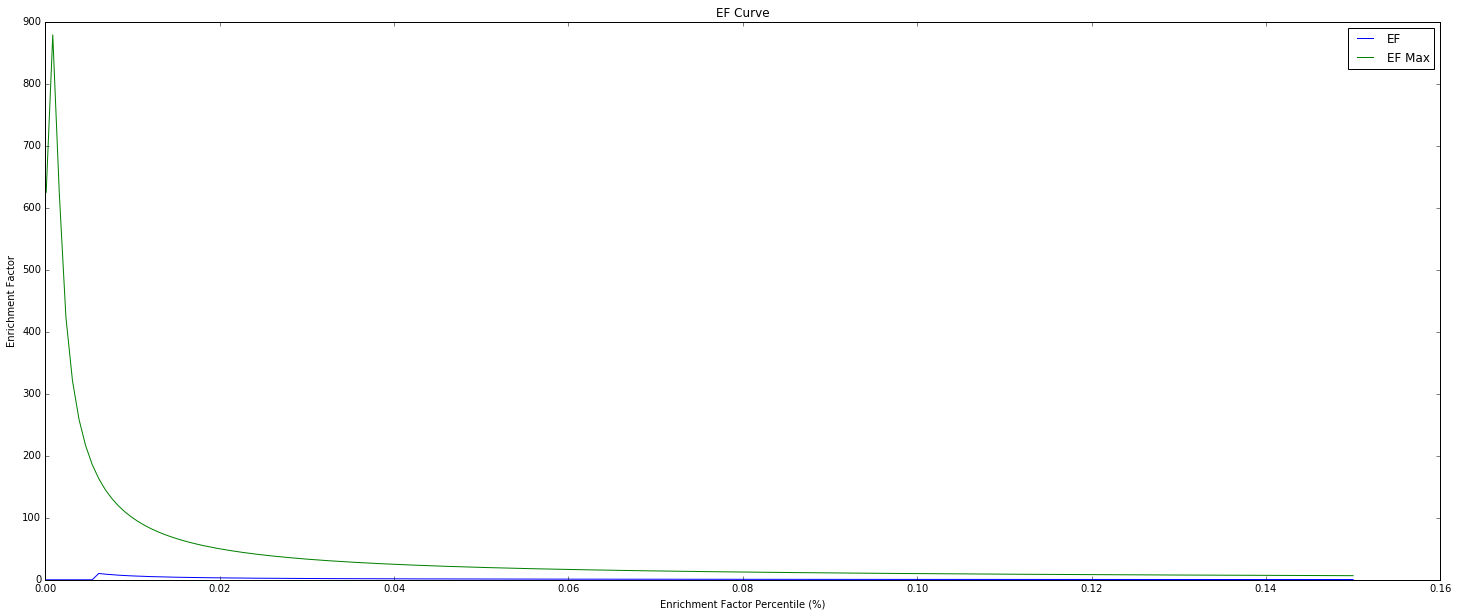

In [16]:
def plot_EF_score_with_existing_model(X_test, y_test, file_path, EF_ratio=0.1):
    model = task.setup_model()
    model.load_weights(file_path)
    y_pred_on_test = model.predict(X_test)
    EF_ratio_list = [0.1, 0.5, 1, 2, 3, 4, 5, 10, 15, 20]
    EF_ratio_list = np.linspace(0.0001, 0.15, 200)
    
    ef_values = []
    ef_max_values = []
    for EF_ratio in EF_ratio_list:
        n_actives, ef, ef_max = enrichment_factor_single(y_test, y_pred_on_test, EF_ratio)
        ef_values.append(ef)
        ef_max_values.append(ef_max)
    
    x_axis = EF_ratio_list
    y_axis = np.array(ef_values)
    plt.plot(x_axis, y_axis)
    
    x_axis = EF_ratio_list
    y_axis = np.array(ef_max_values)
    plt.plot(x_axis, y_axis)
    
    plt.legend(['EF', 'EF Max'])
    
    plt.xlabel('Enrichment Factor Percentile (%)')
    plt.ylabel('Enrichment Factor')
    plt.title('EF Curve')
    plt.show()
    return

plot_EF_score_with_existing_model(X_test, y_test, PMTNN_weight_file)

## Test Label 'Keck_Pria_FP_Retest'

In [17]:
from sklearn.cross_validation import StratifiedShuffleSplit

X_train, y_train = extract_feature_and_label(train_pd,
                                             feature_name='Fingerprints',
                                             label_name_list=['Keck_Pria_FP_data'])
X_test, y_test = extract_feature_and_label(test_pd,
                                           feature_name='Fingerprints',
                                           label_name_list=['Keck_Pria_FP_data'])
cross_validation_split = StratifiedShuffleSplit(y_train, 1, test_size=0.15, random_state=1)
for t_index, val_index in cross_validation_split:
    X_t, X_val = X_train[t_index], X_train[val_index]
    y_t, y_val = y_train[t_index], y_train[val_index]
print 'done data preparation'

(57937, 1)
(14486, 1)
done data preparation


In [18]:
%load_ext autoreload
%autoreload 2
from models.single_classification import *
import time

config_json_file = '../json/single_classification.json'
PMTNN_weight_file = 'temp.h5'
with open(config_json_file, 'r') as f:
    conf = json.load(f)
task = SingleClassification(conf)
start_time = time.time()
task.train_and_predict(X_t, y_t, X_val, y_val, X_test, y_test, PMTNN_weight_file)

duration = time.time() - start_time
print('duration is '),
print(duration)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Epoch 1/10
Train	AUC[ROC]: 0.450395	AUC[BEDROC]: 0.037841	AUC[PR]: 0.000250
Val	AUC[ROC]: 0.598297	AUC[BEDROC]: 0.049003	AUC[PR]: 0.000417

Epoch 2/10
Train	AUC[ROC]: 0.433018	AUC[BEDROC]: 0.029476	AUC[PR]: 0.000241
Val	AUC[ROC]: 0.655387	AUC[BEDROC]: 0.040840	AUC[PR]: 0.000465

Epoch 3/10
Train	AUC[ROC]: 0.478260	AUC[BEDROC]: 0.022110	AUC[PR]: 0.000262
Val	AUC[ROC]: 0.599217	AUC[BEDROC]: 0.032976	AUC[PR]: 0.000411

Epoch 4/10
Train	AUC[ROC]: 0.497497	AUC[BEDROC]: 0.030298	AUC[PR]: 0.000272
Val	AUC[ROC]: 0.687922	AUC[BEDROC]: 0.087613	AUC[PR]: 0.000551

Epoch 5/10
Train	AUC[ROC]: 0.529592	AUC[BEDROC]: 0.049036	AUC[PR]: 0.000295
Val	AUC[ROC]: 0.678752	AUC[BEDROC]: 0.101061	AUC[PR]: 0.000540

Epoch 6/10
Train	AUC[ROC]: 0.504173	AUC[BEDROC]: 0.043151	AUC[PR]: 0.000279
Val	AUC[ROC]: 0.689725	AUC[BEDROC]: 0.139534	AUC[PR]: 0.000603

Epoch 7/10
Train	AUC[ROC]: 0.483362	AUC[BEDROC]: 0.043353	AUC[PR]: 0.000

# Plot EF and EF-Max graph

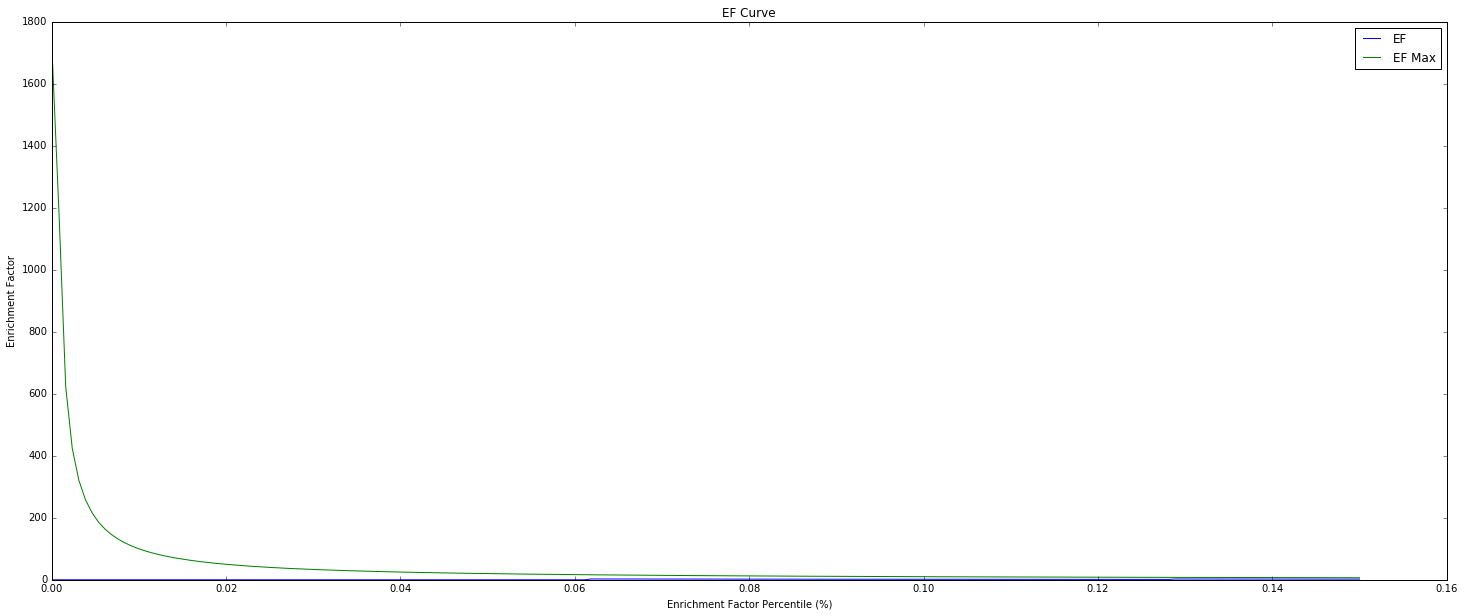

In [19]:
plot_EF_score_with_existing_model(X_test, y_test, PMTNN_weight_file)

# Test Single Regression

In [20]:
from models.single_regression import *
import time

config_json_file = '../json/single_regression.json'
PMTNN_weight_file = 'temp.weight'
config_csv_file = 'temp.csv'

# specify dataset
k = 5
directory = '../dataset/fixed_dataset/fold_{}/'.format(k)
file_list = []
for i in range(k):
    file_list.append('file_{}.csv'.format(i))

# merge training and test dataset
dtype_list = {'Molecule': np.str,
              'SMILES': np.str,
              'Fingerprints': np.str,
              'Keck_Pria_AS_Retest': np.int64,
              'Keck_Pria_FP_data': np.int64,
              'Keck_Pria_Continuous': np.float64,
              'Keck_RMI_cdd': np.float64}
output_file_list = [directory + f_ for f_ in file_list]
print output_file_list[0:4]
train_pd = read_merged_data(output_file_list[0:4])
print output_file_list[4]
test_pd = read_merged_data([output_file_list[4]])

# extract data, and split training data into training and val
X_train, y_train = extract_feature_and_label(train_pd,
                                             feature_name='Fingerprints',
                                             label_name_list=['Keck_Pria_Continuous'])
X_test, y_test = extract_feature_and_label(test_pd,
                                           feature_name='Fingerprints',
                                           label_name_list=['Keck_Pria_Continuous'])
cross_validation_split = ShuffleSplit(y_train.shape[0], n_iter=1, test_size=0.15, random_state=1)
for t_index, val_index in cross_validation_split:
    X_t, X_val = X_train[t_index], X_train[val_index]
    y_t, y_val = y_train[t_index], y_train[val_index]
print 'done data preparation'

with open(config_json_file, 'r') as f:
    conf = json.load(f)
task = SingleClassification(conf=conf)
start_time = time.time()
task.train_and_predict(X_t, y_t, X_val, y_val, X_test, y_test, PMTNN_weight_file)
store_data(transform_json_to_csv(config_json_file), config_csv_file)
duration = time.time() - start_time
print('duration is '),
print(duration)

['../dataset/fixed_dataset/fold_5/file_0.csv', '../dataset/fixed_dataset/fold_5/file_1.csv', '../dataset/fixed_dataset/fold_5/file_2.csv', '../dataset/fixed_dataset/fold_5/file_3.csv']
../dataset/fixed_dataset/fold_5/file_4.csv
(57937, 1)
(14486, 1)
done data preparation
Epoch 1/10
49246/49246 [==============================] - 1s - loss: 188.7573     

# Test Vanilla LSTM

In [21]:
from models.vanilla_lstm import *
import time


config_json_file = '../json/vanilla_lstm.json'
PMTNN_weight_file = 'temp.weight'
config_csv_file = 'temp.csv'

with open(config_json_file, 'r') as f:
    conf = json.load(f)
task = VanillaLSTM(conf)

# specify dataset
k = 5
directory = '../dataset/fixed_dataset/fold_{}/'.format(k)
file_list = []
for i in range(k):
    file_list.append('file_{}.csv'.format(i))

# merge training and test dataset
dtype_list = {'Molecule': np.str,
              'SMILES': np.str,
              'Fingerprints': np.str,
              'Keck_Pria_AS_Retest': np.int64,
              'Keck_Pria_FP_data': np.int64,
              'Keck_Pria_Continuous': np.float64,
              'Keck_RMI_cdd': np.float64}
output_file_list = [directory + f_ for f_ in file_list]
print output_file_list[:4]
train_pd = read_merged_data(output_file_list[0:4])

print output_file_list[4]
test_pd = read_merged_data([output_file_list[4]])

# extract data, and split training data into training and val
X_train, y_train = extract_SMILES_and_label(train_pd,
                                            feature_name='SMILES',
                                            label_name_list=['Keck_Pria_AS_Retest'])
X_test, y_test = extract_SMILES_and_label(test_pd,
                                          feature_name='SMILES',
                                          label_name_list=['Keck_Pria_AS_Retest'])

cross_validation_split = StratifiedShuffleSplit(y_train, 1, test_size=0.15, random_state=1)
for t_index, val_index in cross_validation_split:
    X_t, X_val = X_train[t_index], X_train[val_index]
    y_t, y_val = y_train[t_index], y_train[val_index]
print 'done data preparation'

X_t = sequence.pad_sequences(X_t, maxlen=task.padding_length)
X_val = sequence.pad_sequences(X_val, maxlen=task.padding_length)
X_test = sequence.pad_sequences(X_test, maxlen=task.padding_length)

start_time = time.time()
task.train_and_predict(X_t, y_t, X_val, y_val, X_test, y_test, PMTNN_weight_file)
duration = time.time() - start_time
print('duration is '),
print(duration)

['../dataset/fixed_dataset/fold_5/file_0.csv', '../dataset/fixed_dataset/fold_5/file_1.csv', '../dataset/fixed_dataset/fold_5/file_2.csv', '../dataset/fixed_dataset/fold_5/file_3.csv']
../dataset/fixed_dataset/fold_5/file_4.csv
alphabet set size 34
(57937, 1)
alphabet set size 34
(14486, 1)
done data preparation
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_1 (Embedding)          (None, 91, 30)        1080        embedding_input_1[0][0]          
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 10)            1640        embedding_1[0][0]                
____________________________________________________________________________________________________
dense_16 (Dense)                 (None, 1)             11          lstm_1[0][0] 